# 房價預測 - 資料預處理
## Kaggle Competition: House Prices - Advanced Regression Techniques

本 Notebook 包含完整的資料預處理流程：
1. 載入數據
2. 處理缺失值
3. 處理異常值
4. 特徵工程
5. 特徵編碼
6. 特徵縮放
7. 儲存處理後的數據

In [1]:
# 導入必要的套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

# 設定顯示選項
pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei']
print("套件載入完成！")

套件載入完成！


## 1. 載入數據

In [3]:
# 載入訓練集和測試集
data_path = 'Data/'
train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')

print(f"訓練集大小: {train.shape}")
print(f"測試集大小: {test.shape}")

# 儲存 Id 和目標變數
train_ID = train['Id']
test_ID = test['Id']
y_train = train['SalePrice'].copy()

# 查看目標變數分布
print(f"\nSalePrice 統計:")
print(y_train.describe())
print(f"偏度: {y_train.skew():.4f}")

訓練集大小: (1460, 81)
測試集大小: (1459, 80)

SalePrice 統計:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64
偏度: 1.8829


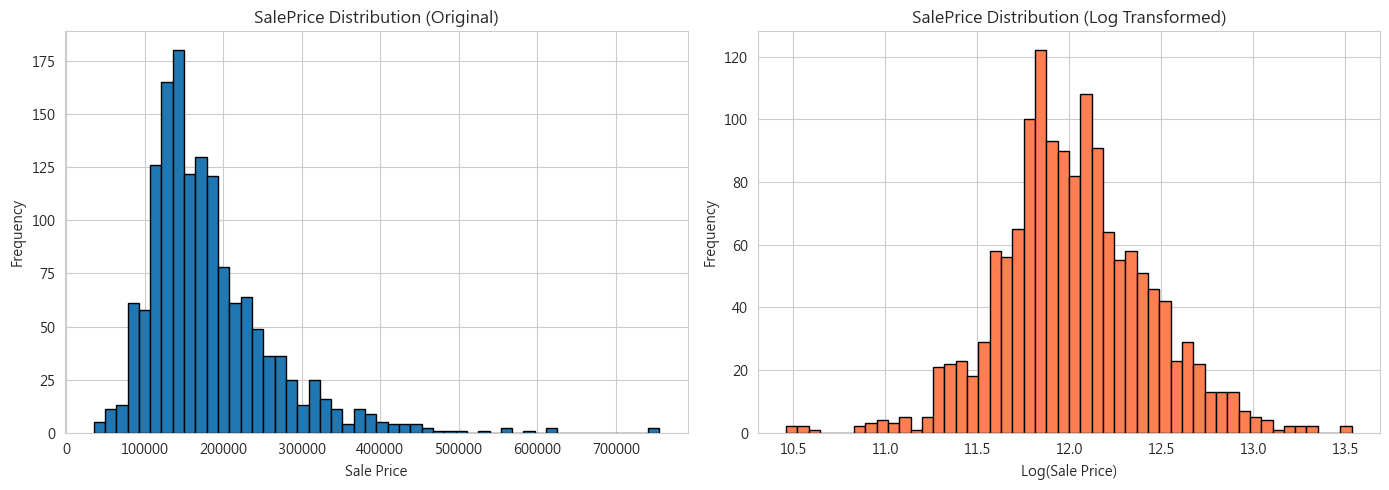

Log 轉換後的偏度: 0.1213


In [4]:
# 視覺化目標變數
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 原始分布
axes[0].hist(y_train, bins=50, edgecolor='black')
axes[0].set_title('SalePrice Distribution (Original)')
axes[0].set_xlabel('Sale Price')
axes[0].set_ylabel('Frequency')

# 對數轉換後
axes[1].hist(np.log1p(y_train), bins=50, edgecolor='black', color='coral')
axes[1].set_title('SalePrice Distribution (Log Transformed)')
axes[1].set_xlabel('Log(Sale Price)')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print(f"Log 轉換後的偏度: {np.log1p(y_train).skew():.4f}")

## 2. 目標變數轉換

由於 SalePrice 呈現右偏分布，我們使用對數轉換來使其更接近常態分布。

In [5]:
# 對數轉換目標變數
y_train_log = np.log1p(y_train)

print(f"原始 SalePrice 偏度: {y_train.skew():.4f}")
print(f"Log 轉換後偏度: {y_train_log.skew():.4f}")
print("\n偏度大幅降低，更接近常態分布!")

原始 SalePrice 偏度: 1.8829
Log 轉換後偏度: 0.1213

偏度大幅降低，更接近常態分布!


## 3. 合併訓練集和測試集

為了確保預處理的一致性，我們先合併兩個數據集，處理完後再分開。

In [6]:
# 移除 Id 和 SalePrice
train = train.drop(['Id', 'SalePrice'], axis=1)
test = test.drop(['Id'], axis=1)

# 記錄訓練集大小
ntrain = train.shape[0]
ntest = test.shape[0]

# 合併
all_data = pd.concat([train, test], axis=0, ignore_index=True)

print(f"合併後數據大小: {all_data.shape}")
print(f"訓練集: {ntrain} 筆")
print(f"測試集: {ntest} 筆")

合併後數據大小: (2919, 79)
訓練集: 1460 筆
測試集: 1459 筆


## 4. 處理異常值

根據 EDA 結果，我們發現有 2 個明顯的異常值：面積很大但價格很低的房屋。

發現 2 個異常值: [523, 1298]


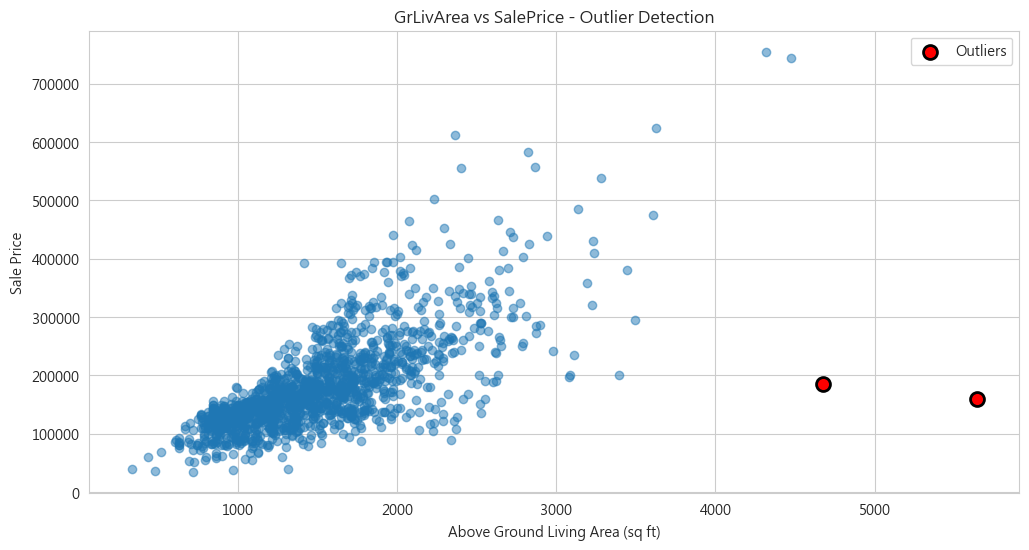

In [7]:
# 視覺化異常值（使用原始訓練集）
fig, ax = plt.subplots(figsize=(12, 6))
ax.scatter(train['GrLivArea'], y_train, alpha=0.5)
ax.set_xlabel('Above Ground Living Area (sq ft)')
ax.set_ylabel('Sale Price')
ax.set_title('GrLivArea vs SalePrice - Outlier Detection')

# 標記異常值
outliers_idx = train[(train['GrLivArea'] > 4000) & (y_train < 300000)].index
if len(outliers_idx) > 0:
    ax.scatter(train.loc[outliers_idx, 'GrLivArea'], 
               y_train.loc[outliers_idx], 
               color='red', s=100, label='Outliers', edgecolors='black', linewidths=2)
    ax.legend()
    print(f"發現 {len(outliers_idx)} 個異常值: {list(outliers_idx)}")

plt.show()

In [8]:
# 移除異常值（從合併的數據中移除對應的訓練集索引）
# 注意：這些索引是基於原始訓練集的
outliers_to_remove = [523, 1298]  # Id 524 和 1299 在 index 中是 523 和 1298

# 從合併數據中移除
all_data = all_data.drop(outliers_to_remove, axis=0).reset_index(drop=True)

# 從目標變數中移除
y_train_log = y_train_log.drop(outliers_to_remove).reset_index(drop=True)
y_train = y_train.drop(outliers_to_remove).reset_index(drop=True)

# 更新訓練集大小
ntrain = ntrain - len(outliers_to_remove)

print(f"移除 {len(outliers_to_remove)} 個異常值")
print(f"新的數據大小: {all_data.shape}")
print(f"新的訓練集大小: {ntrain}")

移除 2 個異常值
新的數據大小: (2917, 79)
新的訓練集大小: 1458


## 5. 缺失值分析

In [9]:
# 計算缺失值
missing = all_data.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_percent = (missing / len(all_data) * 100).round(2)

missing_df = pd.DataFrame({
    '缺失數量': missing,
    '缺失比例(%)': missing_percent
})

print(f"共有 {len(missing)} 個特徵存在缺失值\n")
print(missing_df.head(20))

共有 34 個特徵存在缺失值

              缺失數量  缺失比例(%)
PoolQC        2908    99.69
MiscFeature   2812    96.40
Alley         2719    93.21
Fence         2346    80.43
MasVnrType    1766    60.54
FireplaceQu   1420    48.68
LotFrontage    486    16.66
GarageFinish   159     5.45
GarageQual     159     5.45
GarageCond     159     5.45
GarageYrBlt    159     5.45
GarageType     157     5.38
BsmtExposure    82     2.81
BsmtCond        82     2.81
BsmtQual        81     2.78
BsmtFinType2    80     2.74
BsmtFinType1    79     2.71
MasVnrArea      23     0.79
MSZoning         4     0.14
BsmtFullBath     2     0.07


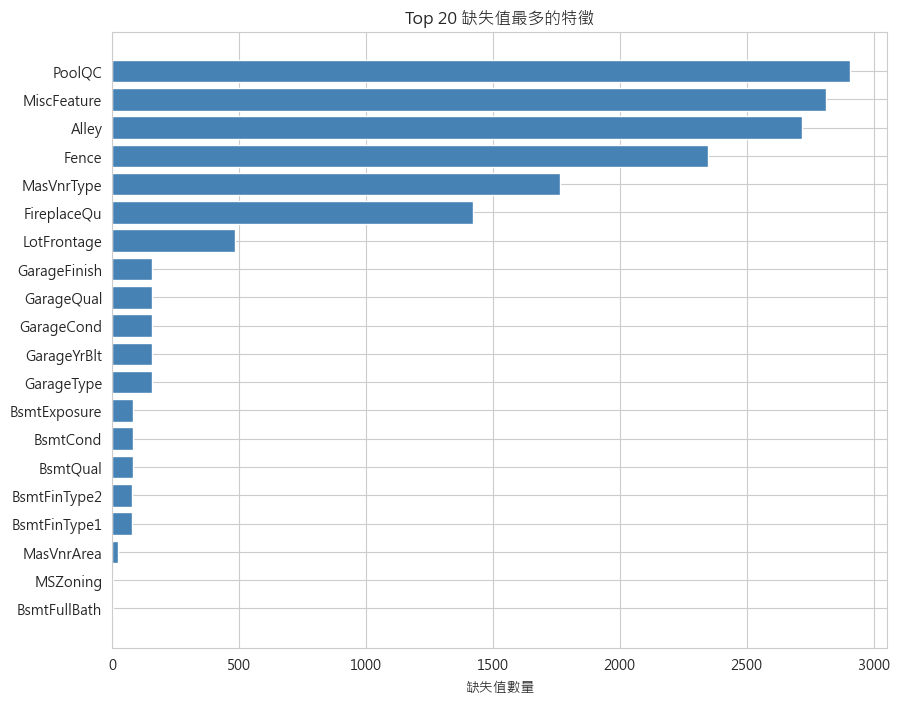

In [10]:
# 視覺化缺失值
plt.figure(figsize=(10, 8))
plt.barh(range(len(missing.head(20))), missing.head(20).values, color='steelblue')
plt.yticks(range(len(missing.head(20))), missing.head(20).index)
plt.xlabel('缺失值數量')
plt.title('Top 20 缺失值最多的特徵')
plt.gca().invert_yaxis()
plt.show()

## 6. 處理缺失值

根據數據描述文件，大部分缺失值實際上代表「無」這個概念。

In [11]:
# 6.1 缺失代表「無」的特徵 - 填充 'None'
none_features = [
    'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu',
    'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
    'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
    'MasVnrType'
]

for col in none_features:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')

print(f"填充 {len(none_features)} 個特徵的缺失值為 'None'")

填充 15 個特徵的缺失值為 'None'


In [12]:
# 6.2 缺失代表 0 的數值特徵
zero_features = [
    'GarageYrBlt', 'GarageArea', 'GarageCars',
    'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
    'BsmtFullBath', 'BsmtHalfBath',
    'MasVnrArea'
]

for col in zero_features:
    if col in all_data.columns:
        all_data[col] = all_data[col].fillna(0)

print(f"填充 {len(zero_features)} 個特徵的缺失值為 0")

填充 10 個特徵的缺失值為 0


In [13]:
# 6.3 LotFrontage - 按 Neighborhood 分組填充中位數
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median())
)

print("LotFrontage 按社區中位數填充完成")

LotFrontage 按社區中位數填充完成


In [14]:
# 6.4 其他類別特徵 - 填充眾數
categorical_features = all_data.select_dtypes(include=['object']).columns

for col in categorical_features:
    if all_data[col].isnull().sum() > 0:
        mode_value = all_data[col].mode()[0] if len(all_data[col].mode()) > 0 else 'None'
        all_data[col] = all_data[col].fillna(mode_value)
        print(f"{col}: 填充眾數 '{mode_value}'")

MSZoning: 填充眾數 'RL'
Utilities: 填充眾數 'AllPub'
Exterior1st: 填充眾數 'VinylSd'
Exterior2nd: 填充眾數 'VinylSd'
Electrical: 填充眾數 'SBrkr'
KitchenQual: 填充眾數 'TA'
Functional: 填充眾數 'Typ'
SaleType: 填充眾數 'WD'


In [15]:
# 6.5 其他數值特徵 - 填充中位數
numerical_features = all_data.select_dtypes(include=[np.number]).columns

for col in numerical_features:
    if all_data[col].isnull().sum() > 0:
        median_value = all_data[col].median()
        all_data[col] = all_data[col].fillna(median_value)
        print(f"{col}: 填充中位數 {median_value}")

In [16]:
# 檢查是否還有缺失值
remaining_missing = all_data.isnull().sum().sum()
print(f"\n剩餘缺失值總數: {remaining_missing}")

if remaining_missing == 0:
    print("✓ 所有缺失值已處理完成！")
else:
    print("還有缺失值需要處理:")
    print(all_data.isnull().sum()[all_data.isnull().sum() > 0])


剩餘缺失值總數: 0
✓ 所有缺失值已處理完成！


## 7. 特徵工程

創建新的有用特徵來提升模型性能。

In [17]:
# 7.1 總面積特徵
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

# 7.2 總衛浴數
all_data['TotalBath'] = (all_data['FullBath'] + 
                         0.5 * all_data['HalfBath'] + 
                         all_data['BsmtFullBath'] + 
                         0.5 * all_data['BsmtHalfBath'])

# 7.3 總門廊面積
all_data['TotalPorchSF'] = (all_data['OpenPorchSF'] + 
                            all_data['EnclosedPorch'] + 
                            all_data['3SsnPorch'] + 
                            all_data['ScreenPorch'])

# 7.4 房屋年齡
all_data['HouseAge'] = all_data['YrSold'] - all_data['YearBuilt']

# 7.5 翻新後年數
all_data['YearsSinceRemod'] = all_data['YrSold'] - all_data['YearRemodAdd']

# 7.6 是否翻新過
all_data['HasRemodeled'] = (all_data['YearRemodAdd'] != all_data['YearBuilt']).astype(int)

# 7.7 是否有地下室
all_data['HasBsmt'] = (all_data['TotalBsmtSF'] > 0).astype(int)

# 7.8 是否有車庫
all_data['HasGarage'] = (all_data['GarageArea'] > 0).astype(int)

# 7.9 是否有壁爐
all_data['HasFireplace'] = (all_data['Fireplaces'] > 0).astype(int)

# 7.10 是否有游泳池
all_data['HasPool'] = (all_data['PoolArea'] > 0).astype(int)

# 7.11 是否有二樓
all_data['Has2ndFloor'] = (all_data['2ndFlrSF'] > 0).astype(int)

print("創建了以下新特徵:")
new_features = ['TotalSF', 'TotalBath', 'TotalPorchSF', 'HouseAge', 'YearsSinceRemod',
                'HasRemodeled', 'HasBsmt', 'HasGarage', 'HasFireplace', 'HasPool', 'Has2ndFloor']
for feat in new_features:
    print(f"  • {feat}")

創建了以下新特徵:
  • TotalSF
  • TotalBath
  • TotalPorchSF
  • HouseAge
  • YearsSinceRemod
  • HasRemodeled
  • HasBsmt
  • HasGarage
  • HasFireplace
  • HasPool
  • Has2ndFloor


In [18]:
# 查看新特徵的統計
all_data[new_features].describe()

,TotalSF,TotalBath,TotalPorchSF,HouseAge,YearsSinceRemod,HasRemodeled,HasBsmt,HasGarage,HasFireplace,HasPool,Has2ndFloor
count,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.000000,2917.00000
mean,2542.521769,2.216832,89.071649,36.504971,23.544738,0.465547,0.972917,0.945835,0.513198,0.004114,0.42818
std,781.071852,0.806907,107.714739,30.331531,20.889738,0.498897,0.162352,0.226382,0.499911,0.064018,0.49490
min,334.000000,1.000000,0.000000,-1.000000,-2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2000.000000,1.500000,0.000000,7.000000,4.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.00000
50%,2448.000000,2.000000,50.000000,35.000000,15.000000,0.000000,1.000000,1.000000,1.000000,0.000000,0.00000
75%,2990.000000,2.500000,136.000000,55.000000,43.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
max,10190.000000,7.000000,1207.000000,136.000000,60.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


## 8. 特徵轉換 - 處理偏度

對高偏度的數值特徵進行 Box-Cox 或對數轉換。

In [19]:
# 計算所有數值特徵的偏度
numerical_features = all_data.select_dtypes(include=[np.number]).columns

skewness = all_data[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=False)

print("高偏度特徵 (|skewness| > 0.75):")
high_skew = skewness[abs(skewness) > 0.75]
print(f"共有 {len(high_skew)} 個高偏度特徵\n")
print(high_skew.head(20))

高偏度特徵 (|skewness| > 0.75):
共有 26 個高偏度特徵

MiscVal          21.939672
PoolArea         17.688664
HasPool          15.494756
LotArea          13.109495
LowQualFinSF     12.084539
3SsnPorch        11.372080
KitchenAbvGr      4.300550
BsmtFinSF2        4.144503
EnclosedPorch     4.002344
ScreenPorch       3.945101
BsmtHalfBath      3.929996
MasVnrArea        2.621719
OpenPorchSF       2.529358
TotalPorchSF      2.244500
WoodDeckSF        1.844792
MSSubClass        1.375131
1stFlrSF          1.257286
LotFrontage       1.103039
GrLivArea         1.068750
TotalSF           1.009157
dtype: float64


In [20]:
# 對高偏度特徵進行 Box-Cox 轉換
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax

skewed_features = skewness[abs(skewness) > 0.75].index

print(f"對 {len(skewed_features)} 個高偏度特徵進行轉換...")

for feat in skewed_features:
    # 使用 Box-Cox 轉換 (lambda = 0.15)
    all_data[feat] = boxcox1p(all_data[feat], 0.15)

print("特徵轉換完成！")

對 26 個高偏度特徵進行轉換...
特徵轉換完成！


In [21]:
# 檢查轉換後的偏度
skewness_after = all_data[skewed_features].apply(lambda x: skew(x)).sort_values(ascending=False)

print("轉換後的偏度 (Top 10):")
print(skewness_after.head(10))

print(f"\n轉換前平均偏度: {abs(skewness[skewed_features]).mean():.4f}")
print(f"轉換後平均偏度: {abs(skewness_after).mean():.4f}")

轉換後的偏度 (Top 10):
PoolArea         15.759529
HasPool          15.494756
3SsnPorch         8.921650
LowQualFinSF      8.741030
MiscVal           5.594963
BsmtHalfBath      3.786685
KitchenAbvGr      3.697303
ScreenPorch       2.977052
BsmtFinSF2        2.563235
EnclosedPorch     2.024321
dtype: float64

轉換前平均偏度: 5.5192
轉換後平均偏度: 3.4150


## 9. 類別特徵編碼

In [22]:
# 9.1 定義有序類別特徵的映射
# 這些特徵有明確的順序關係

# 質量評級 (Po < Fa < TA < Gd < Ex)
quality_map = {'None': 0, 'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}

quality_features = [
    'ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 
    'HeatingQC', 'KitchenQual', 'FireplaceQu', 
    'GarageQual', 'GarageCond', 'PoolQC'
]

for col in quality_features:
    if col in all_data.columns:
        all_data[col] = all_data[col].map(quality_map)

print(f"編碼 {len(quality_features)} 個質量評級特徵")

編碼 10 個質量評級特徵


In [23]:
# 其他有序特徵

# BsmtExposure
bsmt_exposure_map = {'None': 0, 'No': 1, 'Mn': 2, 'Av': 3, 'Gd': 4}
all_data['BsmtExposure'] = all_data['BsmtExposure'].map(bsmt_exposure_map)

# BsmtFinType1 and BsmtFinType2
bsmt_fin_map = {'None': 0, 'Unf': 1, 'LwQ': 2, 'Rec': 3, 'BLQ': 4, 'ALQ': 5, 'GLQ': 6}
all_data['BsmtFinType1'] = all_data['BsmtFinType1'].map(bsmt_fin_map)
all_data['BsmtFinType2'] = all_data['BsmtFinType2'].map(bsmt_fin_map)

# Functional
functional_map = {'Sal': 1, 'Sev': 2, 'Maj2': 3, 'Maj1': 4, 'Mod': 5, 'Min2': 6, 'Min1': 7, 'Typ': 8}
all_data['Functional'] = all_data['Functional'].map(functional_map)

# GarageFinish
garage_finish_map = {'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3}
all_data['GarageFinish'] = all_data['GarageFinish'].map(garage_finish_map)

# Fence
fence_map = {'None': 0, 'MnWw': 1, 'GdWo': 2, 'MnPrv': 3, 'GdPrv': 4}
all_data['Fence'] = all_data['Fence'].map(fence_map)

# LotShape
lotshape_map = {'IR3': 1, 'IR2': 2, 'IR1': 3, 'Reg': 4}
all_data['LotShape'] = all_data['LotShape'].map(lotshape_map)

# Utilities
utilities_map = {'ELO': 1, 'NoSeWa': 2, 'NoSewr': 3, 'AllPub': 4}
all_data['Utilities'] = all_data['Utilities'].map(utilities_map)

# LandSlope
landslope_map = {'Sev': 1, 'Mod': 2, 'Gtl': 3}
all_data['LandSlope'] = all_data['LandSlope'].map(landslope_map)

# PavedDrive
paved_map = {'N': 0, 'P': 1, 'Y': 2}
all_data['PavedDrive'] = all_data['PavedDrive'].map(paved_map)

# Street
street_map = {'Grvl': 0, 'Pave': 1}
all_data['Street'] = all_data['Street'].map(street_map)

# CentralAir
central_air_map = {'N': 0, 'Y': 1}
all_data['CentralAir'] = all_data['CentralAir'].map(central_air_map)

print("有序類別特徵編碼完成")

有序類別特徵編碼完成


In [24]:
# 9.2 One-Hot Encoding 無序類別特徵
# 獲取剩餘的類別特徵
categorical_features = all_data.select_dtypes(include=['object']).columns.tolist()

print(f"需要進行 One-Hot Encoding 的特徵: {len(categorical_features)}")
print(categorical_features)

# One-Hot Encoding
all_data = pd.get_dummies(all_data, columns=categorical_features, drop_first=False)

print(f"\nOne-Hot Encoding 後的特徵數: {all_data.shape[1]}")

需要進行 One-Hot Encoding 的特徵: 21
['MSZoning', 'Alley', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating', 'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition']

One-Hot Encoding 後的特徵數: 233


## 10. 分離訓練集和測試集

In [25]:
# 分離回訓練集和測試集
X_train = all_data[:ntrain].copy()
X_test = all_data[ntrain:].copy()

print(f"訓練集大小: {X_train.shape}")
print(f"測試集大小: {X_test.shape}")
print(f"目標變數大小: {y_train_log.shape}")

# 確認沒有缺失值
print(f"\n訓練集缺失值: {X_train.isnull().sum().sum()}")
print(f"測試集缺失值: {X_test.isnull().sum().sum()}")

訓練集大小: (1458, 233)
測試集大小: (1459, 233)
目標變數大小: (1458,)

訓練集缺失值: 0
測試集缺失值: 0


## 11. 特徵縮放（可選）

對於線性模型（如 Ridge, Lasso），特徵縮放很重要。
對於樹模型（如 XGBoost），則不需要。

In [26]:
# 標準化（如果使用線性模型）
# 注意：這裡先不執行，根據後續使用的模型決定是否需要

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 轉回 DataFrame
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

print("特徵已標準化（儲存為 X_train_scaled 和 X_test_scaled）")
print("如果使用樹模型，可以直接使用 X_train 和 X_test")

特徵已標準化（儲存為 X_train_scaled 和 X_test_scaled）
如果使用樹模型，可以直接使用 X_train 和 X_test


## 12. 儲存預處理後的數據

In [27]:
# 儲存處理後的數據
X_train.to_csv('X_train_processed.csv', index=False)
X_test.to_csv('X_test_processed.csv', index=False)
y_train_log.to_csv('y_train_log.csv', index=False, header=['SalePrice_log'])

# 也儲存標準化版本
X_train_scaled.to_csv('X_train_scaled.csv', index=False)
X_test_scaled.to_csv('X_test_scaled.csv', index=False)

# 儲存 Id 和原始目標變數
train_ID.to_csv('train_ids.csv', index=False, header=['Id'])
test_ID.to_csv('test_ids.csv', index=False, header=['Id'])
y_train.to_csv('y_train_original.csv', index=False, header=['SalePrice'])

print("所有數據已儲存！")
print("\n儲存的檔案:")
print("  • X_train_processed.csv - 預處理後的訓練特徵")
print("  • X_test_processed.csv - 預處理後的測試特徵")
print("  • X_train_scaled.csv - 標準化後的訓練特徵")
print("  • X_test_scaled.csv - 標準化後的測試特徵")
print("  • y_train_log.csv - 對數轉換後的目標變數")
print("  • y_train_original.csv - 原始目標變數")
print("  • train_ids.csv - 訓練集 ID")
print("  • test_ids.csv - 測試集 ID")

所有數據已儲存！

儲存的檔案:
  • X_train_processed.csv - 預處理後的訓練特徵
  • X_test_processed.csv - 預處理後的測試特徵
  • X_train_scaled.csv - 標準化後的訓練特徵
  • X_test_scaled.csv - 標準化後的測試特徵
  • y_train_log.csv - 對數轉換後的目標變數
  • y_train_original.csv - 原始目標變數
  • train_ids.csv - 訓練集 ID
  • test_ids.csv - 測試集 ID


## 13. 預處理總結

In [29]:
print("=" * 80)
print("資料預處理總結")
print("=" * 80)
print(f"\n1. 目標變數轉換:")
print(f"   - 對 SalePrice 進行 log1p 轉換")
print(f"   - 偏度從 {y_train.skew():.4f} 降至 {y_train_log.skew():.4f}")

print(f"\n2. 異常值處理:")
print(f"   - 移除 2 個明顯異常值")

print(f"\n3. 缺失值處理:")
print(f"   - 所有缺失值已處理完成")
print(f"   - 根據特徵含義分別處理")

print(f"\n4. 特徵工程:")
print(f"   - 創建 11 個新特徵")
print(f"   - 包括總面積、總衛浴數、房屋年齡等")

print(f"\n5. 特徵轉換:")
print(f"   - 對 {len(skewed_features)} 個高偏度特徵進行 Box-Cox 轉換")

print(f"\n6. 特徵編碼:")
print(f"   - 有序類別特徵: Ordinal Encoding")
print(f"   - 無序類別特徵: One-Hot Encoding")

print(f"\n7. 最終數據形狀:")
print(f"   - 訓練集: {X_train.shape}")
print(f"   - 測試集: {X_test.shape}")
print(f"   - 特徵總數: {X_train.shape[1]}")


資料預處理總結

1. 目標變數轉換:
   - 對 SalePrice 進行 log1p 轉換
   - 偏度從 1.8813 降至 0.1216

2. 異常值處理:
   - 移除 2 個明顯異常值

3. 缺失值處理:
   - 所有缺失值已處理完成
   - 根據特徵含義分別處理

4. 特徵工程:
   - 創建 11 個新特徵
   - 包括總面積、總衛浴數、房屋年齡等

5. 特徵轉換:
   - 對 26 個高偏度特徵進行 Box-Cox 轉換

6. 特徵編碼:
   - 有序類別特徵: Ordinal Encoding
   - 無序類別特徵: One-Hot Encoding

7. 最終數據形狀:
   - 訓練集: (1458, 233)
   - 測試集: (1459, 233)
   - 特徵總數: 233
